# Import and Initialize

In [1]:
!pip install visualkeras

     |████████████████████████████████| 989 kB 4.1 MB/s eta 0:00:01


In [2]:
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Image
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

In [3]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2022-11-12 09:57:05.636723: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-12 09:57:05.636849: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-11-12 09:57:10.838198: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-12 09:57:10.840808: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-12 09:57:10.840859: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-12 09:57:10.840890: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7e3c1e082667): /proc/driver/nvidia/version does not exist
2022-11-12 09:57:10.843705: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


In [4]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH

'gs://kds-c91a6fc4d0970368a75392b7026120c64ec941df0e114d88f99e8f60'

# Import Data

In [5]:
IMAGE_FEATURE_DESCRIPTION = {
    "image_name": tf.io.FixedLenFeature([], tf.string),
    "image": tf.io.FixedLenFeature([], tf.string),
    "target": tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, IMAGE_FEATURE_DESCRIPTION)

## Monet Files

In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

Monet TFRecord Files: 5


2022-11-12 09:57:17.755994: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [7]:
raw_monet_images = [tf.data.TFRecordDataset(x) for x in MONET_FILENAMES]
raw_monet_image_dataset = raw_monet_images[0]
type(raw_monet_image_dataset), raw_monet_image_dataset

(tensorflow.python.data.ops.readers.TFRecordDatasetV2,
 <TFRecordDatasetV2 shapes: (), types: tf.string>)

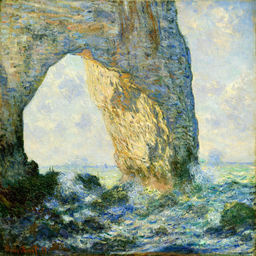

In [8]:
parsed_monet_image_dataset = raw_monet_image_dataset.map(_parse_image_function)

monet_image = next(iter(parsed_monet_image_dataset))['image'].numpy()
display(Image(data=monet_image))

## Base Pictures

In [9]:
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Photo TFRecord Files: 20


2022-11-12 09:57:18.436338: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


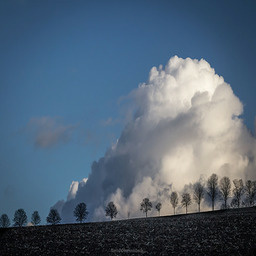

In [10]:
raw_base_images = [tf.data.TFRecordDataset(x) for x in PHOTO_FILENAMES]
raw_base_image_dataset = raw_base_images[0]

parsed_base_image_dataset = raw_base_image_dataset.map(_parse_image_function)

base_image = next(iter(parsed_base_image_dataset))['image'].numpy()
display(Image(data=base_image))

# Image Preprocessing

## Raw Images to Numpy Arrays

In [11]:
import numpy as np
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 ## Scale 0->255 to -1->1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    example = _parse_image_function(example)
    image = decode_image(example['image'])
    return image

(256, 256, 3)


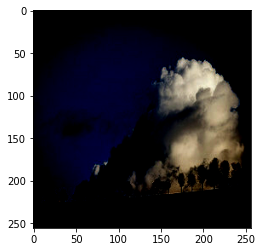

In [12]:
n_arr = read_tfrecord(next(iter(raw_base_image_dataset)))
print(n_arr.shape)

# plt.figure(figsize = (10,10))
plt.imshow(n_arr)

In [13]:
IMG_SHAPE = np.array(n_arr.shape)
IMG_SHAPE

array([256, 256,   3])

## Building Generator

- Using a [UNET archietecture](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5) because, we don't just want to simply classify the image as monet-or-not but rather convert EVERY pixel to monet-style

In [14]:
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Conv2DTranspose, Input, MaxPooling2D, concatenate, ZeroPadding2D, LeakyReLU, GaussianNoise

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # stop displaying warnings that mean nothing!!!

In [15]:
def layer(input_layer, filters, kernel_size=(4,4),activation="relu",
          stride=1, padding='same',name=None, normalisation = True):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
    kernel_initializer=tf.random_normal_initializer(0., 0.2)
    filters = min(filters, 512)
    
    _ = Conv2D(filters, kernel_size=kernel_size, activation=activation, padding=padding, strides=stride, kernel_initializer=kernel_initializer, use_bias=False, name=name)(input_layer)
    if normalisation:
        _ = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(_)
#     name = name+'.2' if name else name
#     _ = Conv2D(filters, kernel_size=kernel_size, activation=activation, padding=padding, strides=stride, kernel_initializer=kernel_initializer, use_bias=False, name=name)(_)
#     if normalisation:
#         _ = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(_)
 
    _ = Dropout(0.25)(_)
    
    return _

In [16]:
def generator_model(name):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
    kernel_initializer=tf.random_normal_initializer(0., 0.2)
    
    # Downsample
    print(IMG_SHAPE)
    inp = Input(shape=IMG_SHAPE)
    down0 = layer(inp,64,name='down0')
    _ = MaxPooling2D((2,2))(down0)
    down1 = layer(_,128,name='down1')
    _ = MaxPooling2D((2,2))(down1)
    down2 = layer(_,256,name='down2')
    _ = MaxPooling2D((2,2))(down2)
    down3 = layer(_,512,name='down3')
    _ = MaxPooling2D((2,2))(down3)
    down4 = layer(_,512,name='down4')
    _ = MaxPooling2D((2,2))(down4)
    
    mid = Conv2D(1024, kernel_size=(4,4), activation="relu", padding="same", strides=1, kernel_initializer=kernel_initializer, use_bias=False, name='mid')(_)
    
    # Upsample
    up4 = Conv2DTranspose(512, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(mid) 
    up4 = concatenate([up4, down4])
    up4 = Dropout(0.5)(up4)
    up4 = layer(up4,512,name='up4')
    
    up3 = Conv2DTranspose(512, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(up4) 
    up3 = Dropout(0.5)(up3)
    up3 = concatenate([up3, down3])
    up3 = layer(up3,512,name='up3')
    
    up2 = Conv2DTranspose(256, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(up3) 
    up2 = Dropout(0.5)(up2)
    up2 = concatenate([up2, down2])
    up2 = layer(up2,256,name='up2')
    
    up1 = Conv2DTranspose(128, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(up2) 
    up1 = Dropout(0.5)(up1)
    up1 = concatenate([up1, down1])
    up1 = layer(up1,128,name='up1')
    
    up0 = Conv2DTranspose(64, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(up1) 
    up0 = Dropout(0.5)(up0)
    up0 = concatenate([up0, down0])
    up0 = layer(up0,64,name='up0')
    
    output_layer = Conv2D(3, (1,1), padding="same", activation="sigmoid")(up0)
    
    
    model = Model(inp,output_layer,name=name) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='mean_squared_error')
    
    return model

generator_mod = generator_model(name = 'Generator_UNET');

[256 256   3]


In [17]:
# from keras.utils.vis_utils import plot_model
# plot_model(generator_mod, show_shapes=True, to_file='generator_mod.png', show_layer_names=True);

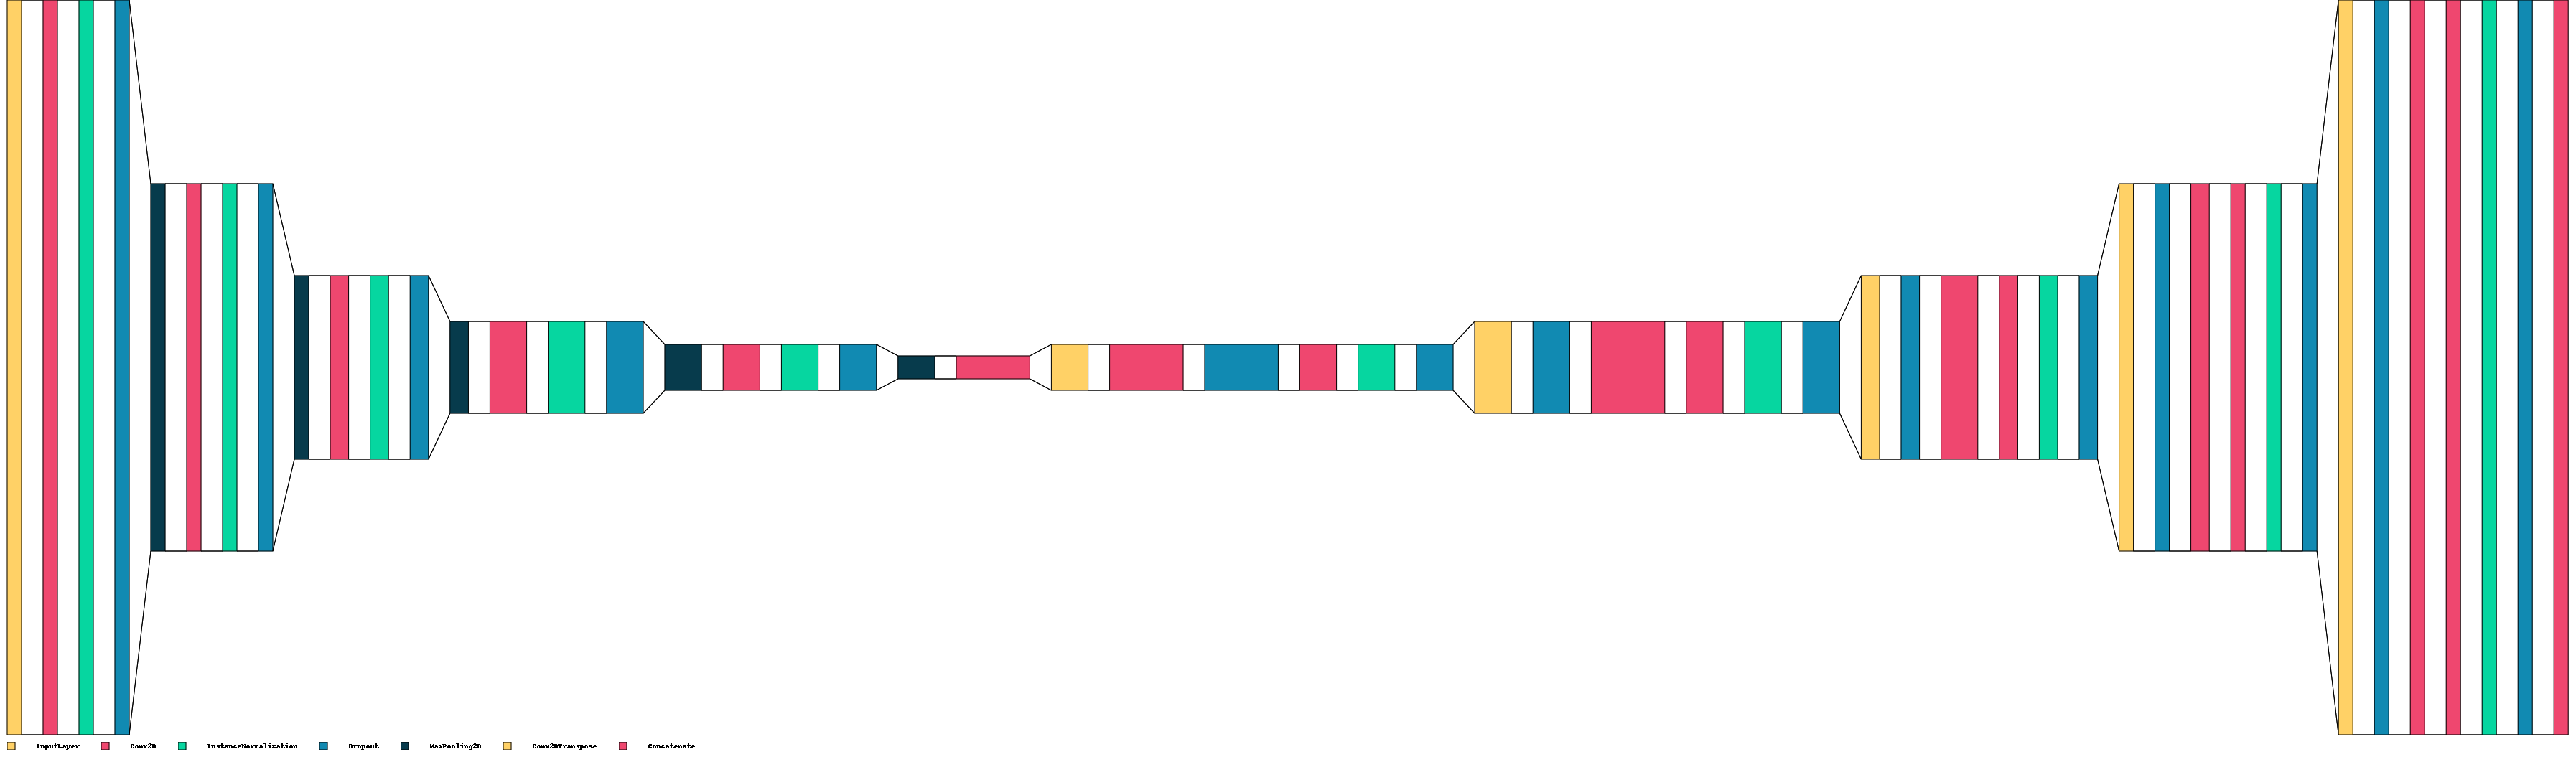

In [18]:
import visualkeras
visualkeras.layered_view(generator_mod, legend=True, draw_volume=False,spacing=30)

## Building the Discriminator

In [72]:
def discriminator_model(name):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
    kernel_initializer=tf.random_normal_initializer(0.0, 0.2)
    
    # Downsample
    inp = Input(shape=IMG_SHAPE)
    noise = GaussianNoise(0.1)(inp)
    
    down0 = layer(noise,128, normalisation=False,name='down0.1')
    down0 = layer(down0,128, normalisation=False,name='down0.2')
    down0 = layer(down0,128, normalisation=False,name='down0.3')
    _ = MaxPooling2D((2,2))(down0)
    down1 = layer(_,256,name='down1.1')
    down1 = layer(down1,256,name='down1.2')
    down1 = layer(down1,256,name='down1.3')
    _ = MaxPooling2D((2,2))(down1)
    down2 = layer(_,512,name='down2.1')
    down2 = layer(down2,512,name='down2.2')
    down2 = layer(down2,512,name='down2.3')
    _ = MaxPooling2D((2,2))(down2)
    
    zero_pad1 = ZeroPadding2D()(_) # (bs, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1,
                         kernel_initializer=kernel_initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = LeakyReLU()(norm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = Conv2D(1, 4, strides=1,
                         kernel_initializer=kernel_initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)
    
discriminator_mod = discriminator_model(name = 'Discriminator');

# discriminator_mod.summary()

In [73]:
# plot_model(discriminator_mod, show_shapes=True, to_file='discriminator_mod.png', show_layer_names=True);

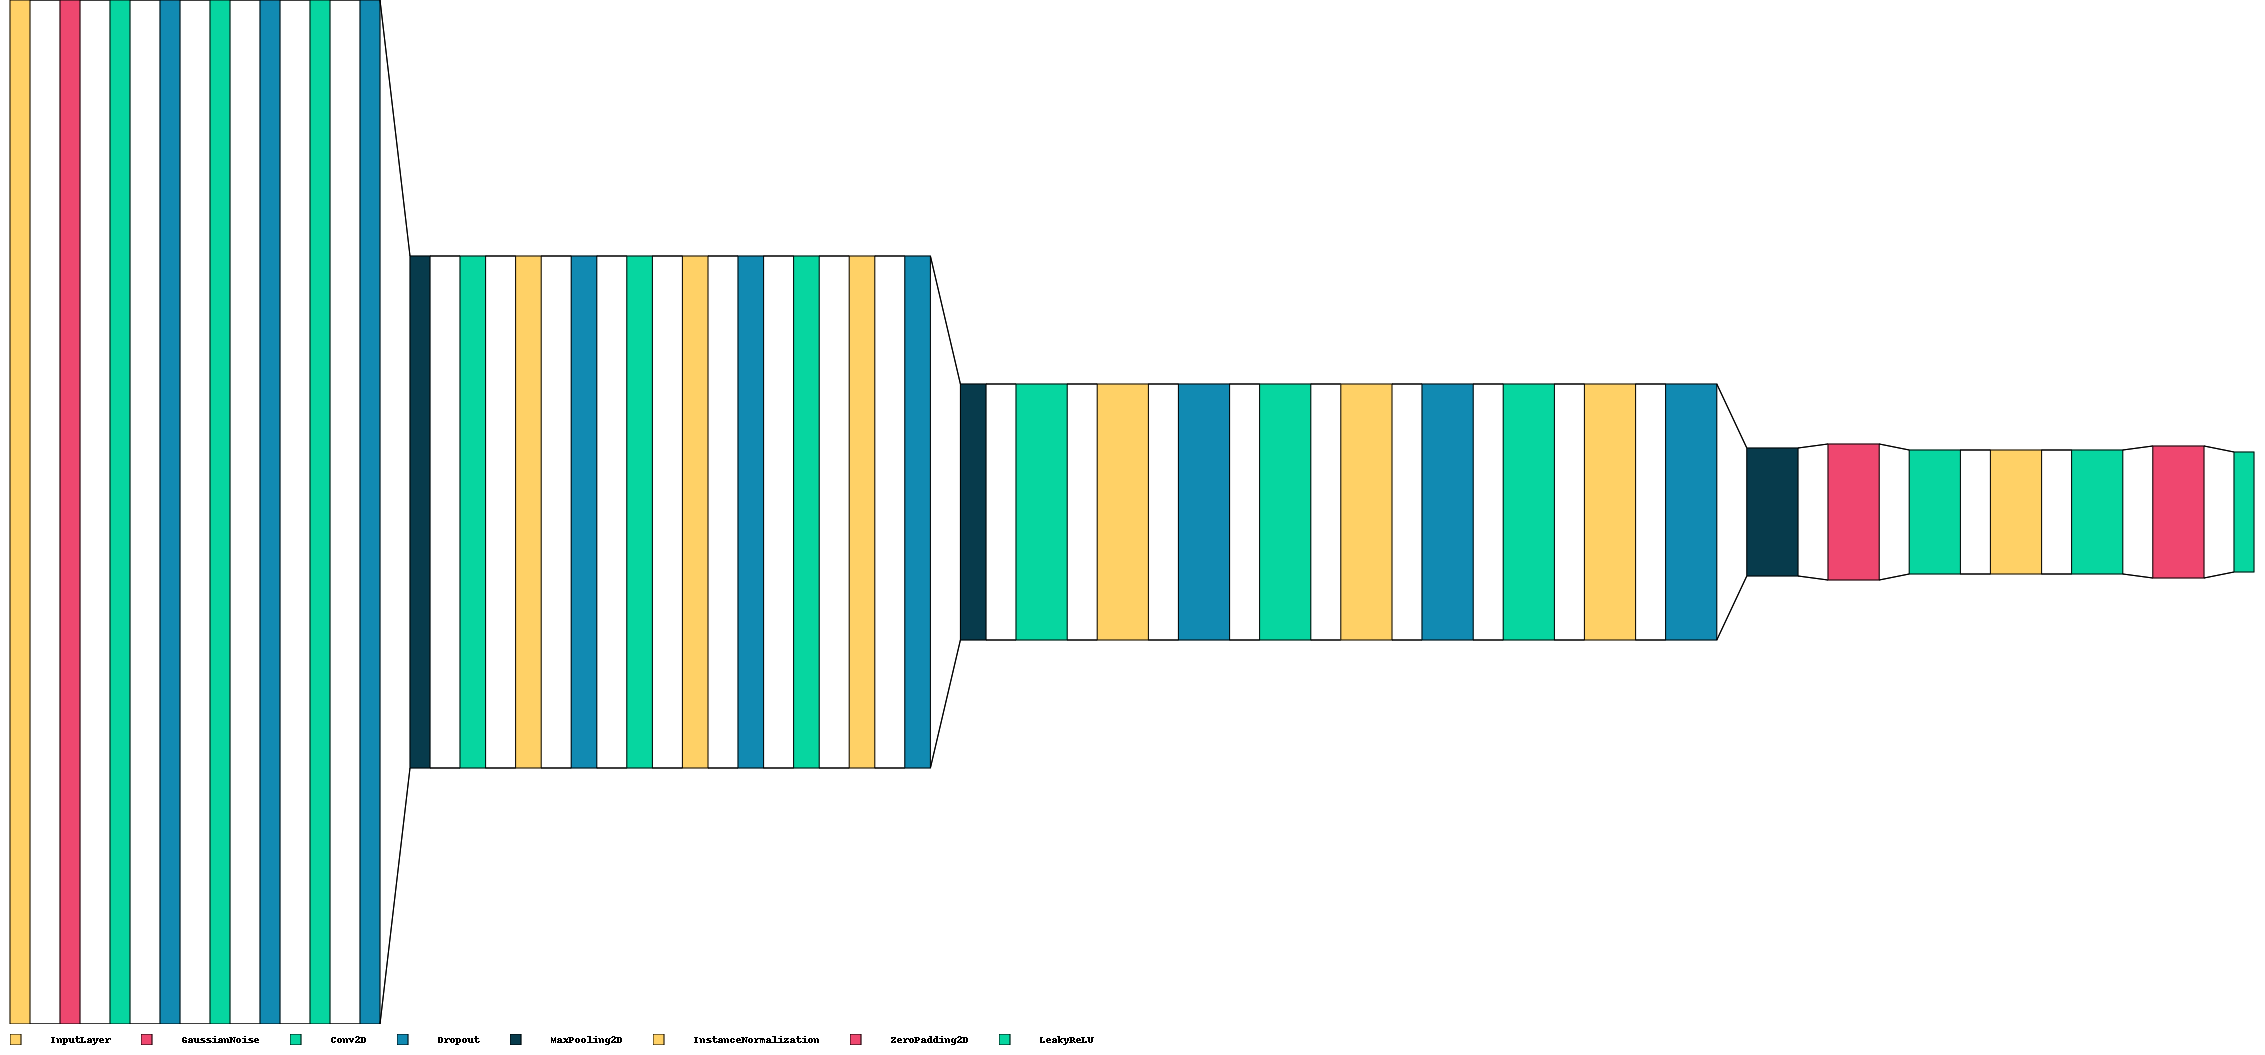

In [74]:
visualkeras.layered_view(discriminator_mod, legend=True, draw_volume=False,spacing=30)

In [75]:
del discriminator_mod
del generator_mod;

NameError: name 'generator_mod' is not defined

# Generate Monet

In [76]:
with strategy.scope():
    monet_generator = generator_model('monet_generator') # transforms photos to Monet-esque paintings
    photo_generator = generator_model('photo_generator') # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_model('monet_discriminator') # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_model('photo_discriminator') # differentiates real photos and generated photos

[256 256   3]
[256 256   3]


In [77]:
def load_dataset(file_list):
    raw_images = tf.data.TFRecordDataset(file_list)
    raw_images = raw_images.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return raw_images

In [78]:
monet_ds = load_dataset(MONET_FILENAMES).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(1)
_=iter(photo_ds)

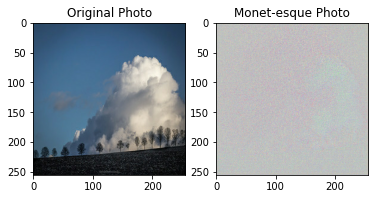

In [79]:
example_photo = next(_)
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(((example_photo[0] * 0.5) + 0.5))

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(((to_monet[0] * 0.5) + 0.5))
plt.show()

# Building CycleGAN

In [158]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=1,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            fake_monet = (fake_monet-0.5)*2##
            cycled_photo = self.p_gen(fake_monet, training=True)
            cycled_photo = (cycled_photo-0.5)*2##

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            fake_photo = (fake_photo-0.5)*2##
            cycled_monet = self.m_gen(fake_photo, training=True)
            cycled_monet = (cycled_monet-0.5)*2##
            
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_monet = (same_monet-0.5)*2##
            same_photo = self.p_gen(real_photo, training=True)
            same_photo = (same_photo-0.5)*2##

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

In [159]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [160]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [161]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [162]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [163]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [164]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=5
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [165]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

Epoch 1/5
300/300 [==============================] - 295s 533ms/step - monet_gen_loss: 8.7411 - photo_gen_loss: 8.4005 - monet_disc_loss: 0.3822 - photo_disc_loss: 0.4655
Epoch 2/5


2022-11-12 11:31:08.366447: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 242179, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1668252668.366316031","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 242179, Output num: 2","grpc_status":3}


300/300 [==============================] - 160s 534ms/step - monet_gen_loss: 6.0851 - photo_gen_loss: 6.6157 - monet_disc_loss: 0.4332 - photo_disc_loss: 0.3447
Epoch 3/5
300/300 [==============================] - 160s 533ms/step - monet_gen_loss: 5.5118 - photo_gen_loss: 6.0484 - monet_disc_loss: 0.3931 - photo_disc_loss: 0.2998
Epoch 4/5
300/300 [==============================] - 160s 533ms/step - monet_gen_loss: 5.3756 - photo_gen_loss: 5.7275 - monet_disc_loss: 0.3705 - photo_disc_loss: 0.3580
Epoch 5/5
300/300 [==============================] - 160s 534ms/step - monet_gen_loss: 5.2698 - photo_gen_loss: 5.9003 - monet_disc_loss: 0.3235 - photo_disc_loss: 0.2561


2022-11-12 11:41:51.905641: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 256034, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1668253311.905497212","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 256034, Output num: 0","grpc_status":3}


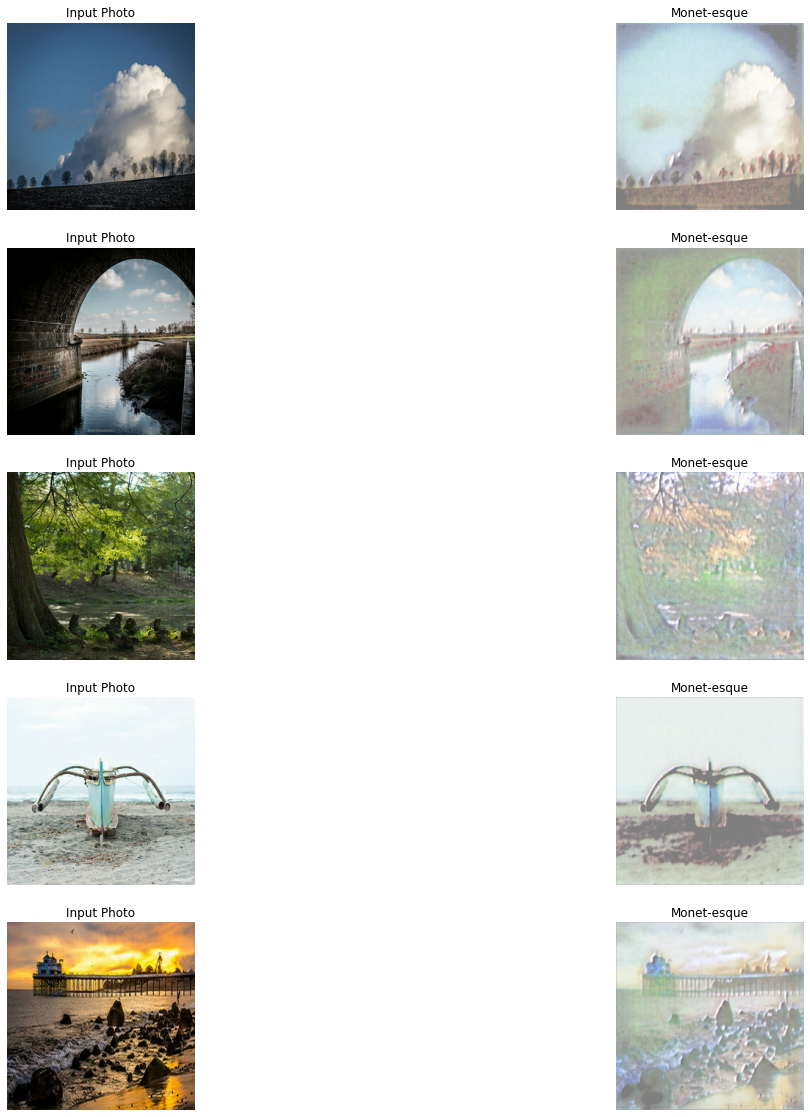

In [166]:
_, ax = plt.subplots(5, 2, figsize=(20, 20))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

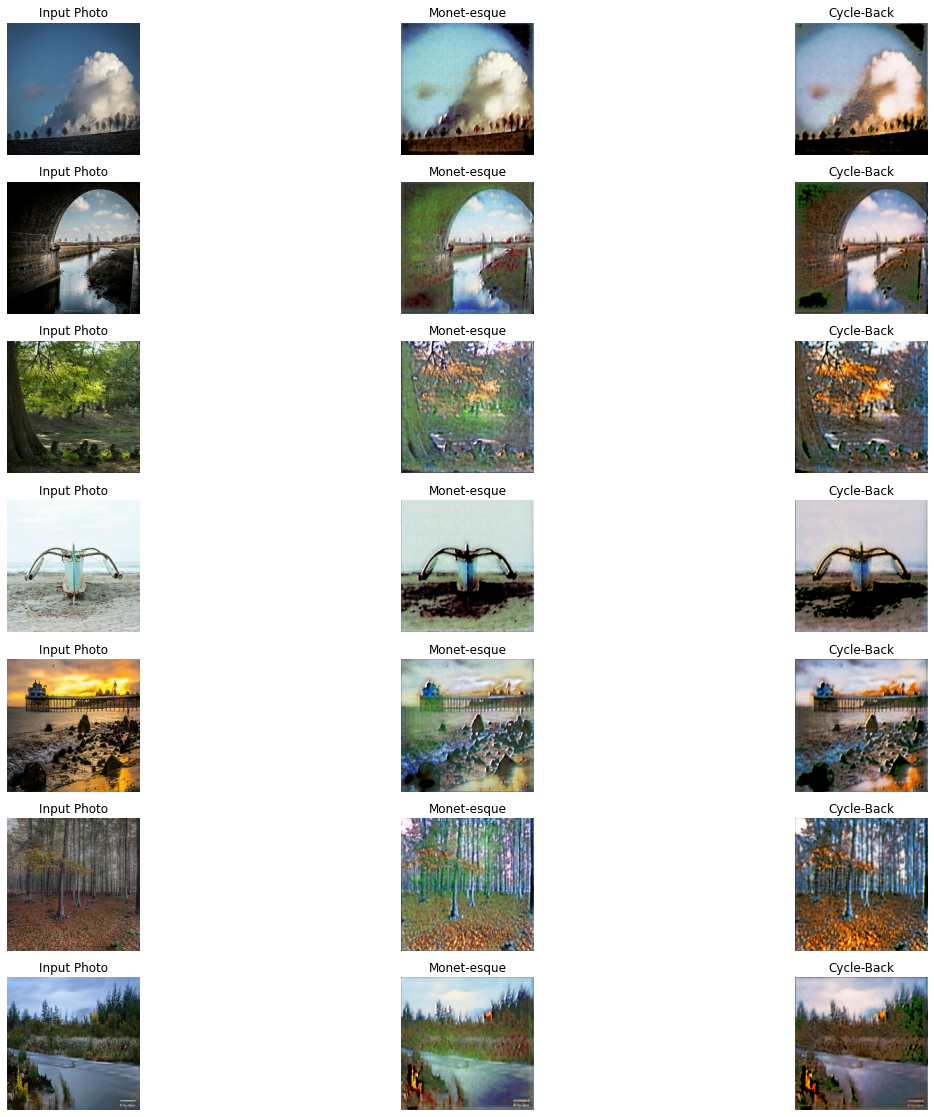

In [167]:
n = 7
_, ax = plt.subplots(n, 3, figsize=(20, 20))
for i, img in enumerate(photo_ds.take(n)):
    prediction = monet_generator(img, training=False)
    prediction = (prediction-0.5)*2
    cycle_back = photo_generator(prediction)
    cycle_back = (cycle_back-0.5)*2
    
    prediction = prediction[0].numpy()
    cycle_back = cycle_back[0].numpy()
    
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    cycle_back = (cycle_back * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(cycle_back)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 2].set_title("Cycle-Back")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()

0 255
0 246
0 255


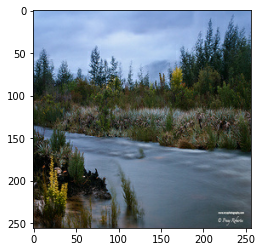

In [168]:
_ = (img)
print(np.min(_[:,:,0]), np.max(_[:,:,0]))
print(np.min(_[:,:,1]), np.max(_[:,:,1]))
print(np.min(_[:,:,2]), np.max(_[:,:,2]))
plt.imshow(_)

0 254
0 252
0 254


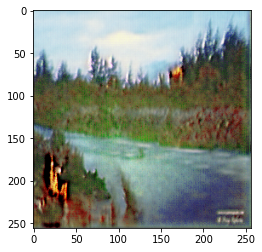

In [169]:
_ = (prediction)
print(np.min(_[:,:,0]), np.max(_[:,:,0]))
print(np.min(_[:,:,1]), np.max(_[:,:,1]))
print(np.min(_[:,:,2]), np.max(_[:,:,2]))
plt.imshow(_)

0 254
0 241
0 234


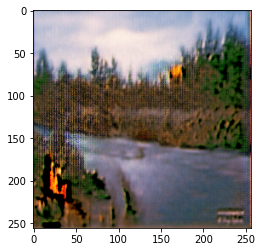

In [170]:
_ = (cycle_back)
print(np.min(_[:,:,0]), np.max(_[:,:,0]))
print(np.min(_[:,:,1]), np.max(_[:,:,1]))
print(np.min(_[:,:,2]), np.max(_[:,:,2]))
plt.imshow(_)

---